In this notebook we will:
1. Evaluate bias in the current model  
2. Compute fairness metrics  
3. Identify problematic features  
4. Mitigate bias (e.g. drop or transform features)  
5. Re-train the model  
6. Compare “before vs after” on both performance and fairness  


In [4]:
import sys
from pathlib import Path

project_root = Path().cwd().parent
sys.path.append(str(project_root))

from src.data_loading.data_loader import load_processed_data, get_numerical_features, get_categorical_features

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
df = load_processed_data()  


Loading processed data from /Users/nando/Documents/GitHub/Credit_Score_Classification/data/processed/preprocessed_dataset_first_10k_rows.csv
Loaded processed dataset with 10000 rows and 32 columns


In [6]:
X = df.drop("Credit_Score", axis=1)
y = df["Credit_Score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Train set: {X_train.shape[0]} rows, Test set: {X_test.shape[0]} rows")


Train set: 8000 rows, Test set: 2000 rows


## 1- Build & Train Baseline Pipeline

We’ll assemble a minimal `ColumnTransformer` + `RandomForestClassifier`.


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# feature lists
num_feats = get_numerical_features(X_train)
cat_feats = get_categorical_features(X_train)

# pipeline per le variabili numeriche (solo scaling)
num_pipeline = Pipeline([
    ("scaler", StandardScaler()),
])

# pipeline per le variabili categoriche (solo one-hot encoding)
cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

# preprocessor che unisce le due pipeline
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_feats),
    ("cat", cat_pipeline, cat_feats),
])

# pipeline finale con classificatore
baseline_pipe = Pipeline([
    ("preproc", preprocessor),
    ("clf", RandomForestClassifier(random_state=42, n_estimators=100)),
])

baseline_pipe.fit(X_train, y_train)
print("Pipeline trained.")    


Pipeline trained.


## 2- Baseline Evaluation

Compute standard metrics 


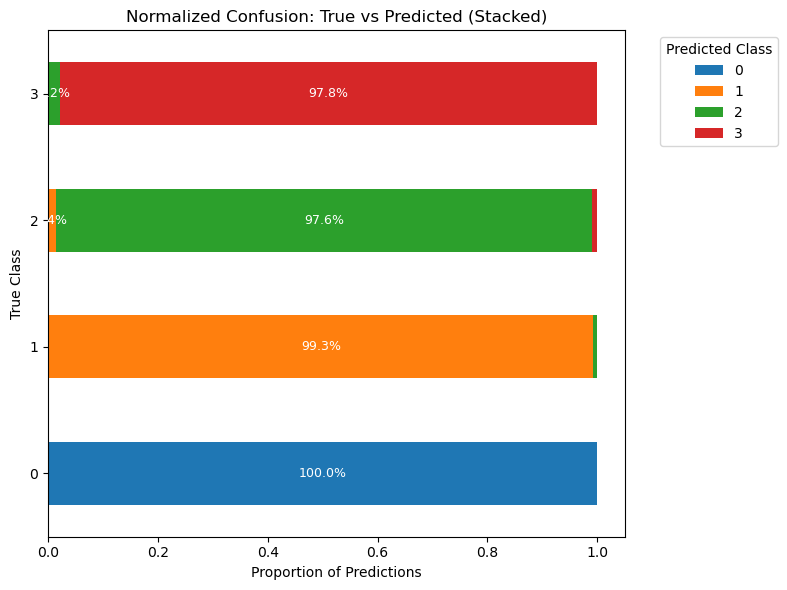

In [25]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Baseline predictions
y_pred_base = baseline_pipe.predict(X_test)

# Compute and normalize confusion matrix by true class (rows sum to 1)
cm = confusion_matrix(y_test, y_pred_base)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Class labels (ensure correct order)
labels = np.unique(y_test)

# Create DataFrame for plotting
df_cm = pd.DataFrame(cm_norm, index=labels, columns=labels)

# Plot stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
df_cm.plot(kind='barh', stacked=True, ax=ax, legend=False)

# Annotate percentages inside bars
for i, true_class in enumerate(df_cm.index):
    cum_width = 0
    for pred_class in df_cm.columns:
        val = df_cm.loc[true_class, pred_class]
        if val > 0.01:  # only annotate segments >1%
            ax.text(
                cum_width + val / 2,
                i,
                f"{val*100:.1f}%",
                va='center',
                ha='center',
                color='white',
                fontsize=9
            )
        cum_width += val

# Aesthetics
ax.set_title("Normalized Confusion: True vs Predicted (Stacked)")
ax.set_xlabel("Proportion of Predictions")
ax.set_ylabel("True Class")
ax.legend(title="Predicted Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 3- Identify Biased Feature

Check if predictions differ across the sensitive feature **City**.


Predicted distribution by City:


col_0,0,1,2,3
City,,,,
BadShire,0.0,1.0,0.000000,0.000000
Lonton,0.0,0.0,0.010811,0.989189
Standhampton,0.0,0.0,1.000000,0.000000
ZeroVille,1.0,0.0,0.000000,0.000000


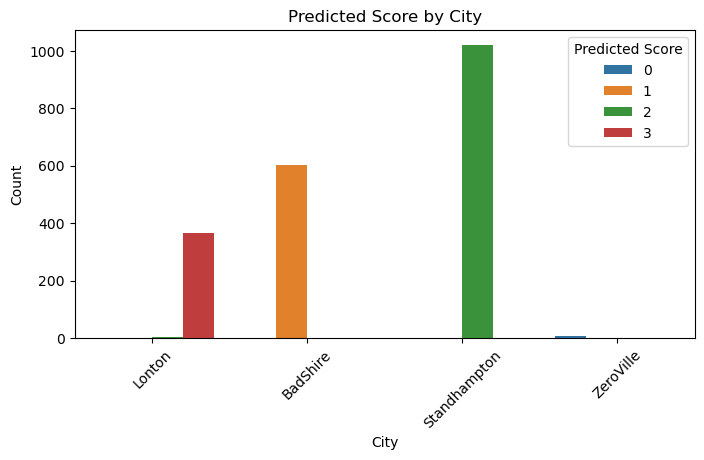

In [10]:
print("Predicted distribution by City:")
display(pd.crosstab(X_test["City"], y_pred_base, normalize="index"))

# Visualize with countplot
plt.figure(figsize=(8,4))
sns.countplot(x="City", hue=y_pred_base, data=X_test.assign(pred=y_pred_base))
plt.title("Predicted Score by City")
plt.xticks(rotation=45)
plt.xlabel("City")
plt.ylabel("Count")
plt.legend(title="Predicted Score")
plt.show()


Predicted distribution by Occupation:


col_0,0,1,2,3
Occupation,,,,
Accountant,0.000000,0.000000,0.069767,0.930233
Architect,0.005168,0.121447,0.767442,0.105943
Artist,0.000000,0.853333,0.146667,0.000000
Cleaner,0.000000,0.835443,0.164557,0.000000
Developer,0.000000,0.000000,0.151515,0.848485
Doctor,0.000000,0.000000,0.166667,0.833333
Engineer,0.000000,0.000000,0.196078,0.803922
Entrepreneur,0.000000,0.000000,0.147059,0.852941
Farmer,0.000000,0.785714,0.214286,0.000000


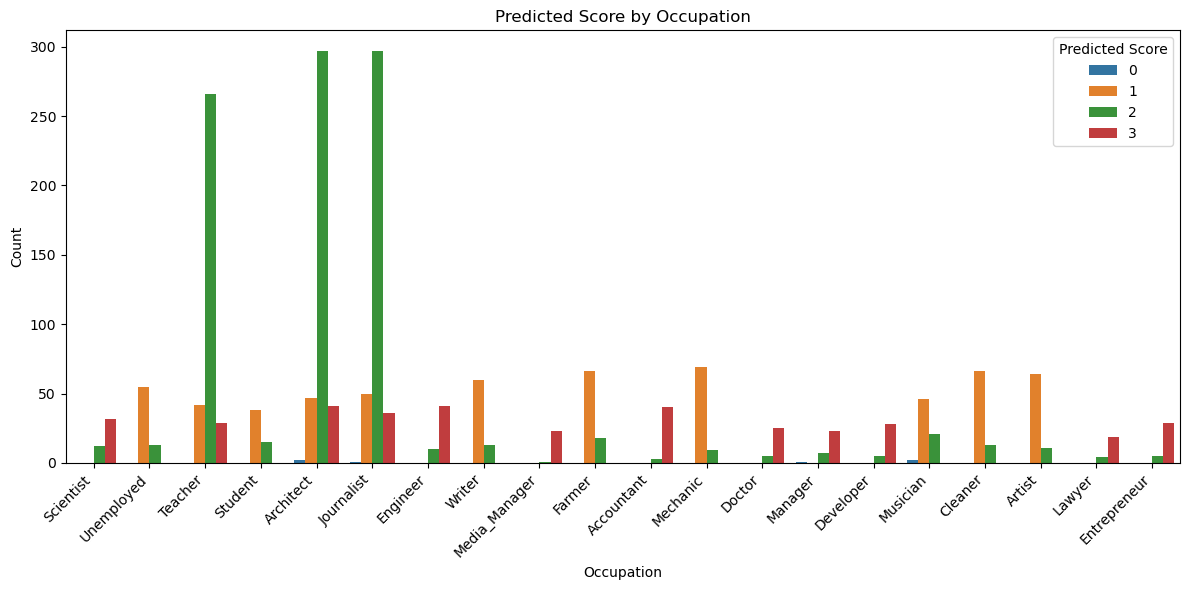

In [14]:
# Predicted distribution by Occupation
print("Predicted distribution by Occupation:")
display(
    pd.crosstab(
        X_test["Occupation"],
        y_pred_base,
        normalize="index"
    )
)

# Visualize with countplot
plt.figure(figsize=(12, 6))
sns.countplot(
    x="Occupation",
    hue=y_pred_base,
    data=X_test.assign(pred=y_pred_base)
)
plt.title("Predicted Score by Occupation")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.legend(title="Predicted Score")
plt.tight_layout()
plt.show()


## 4- Mitigation: Drop “City” and "Occupation"

We’ll remove **City** and **Occupation** from features, rebuild & re-train.


In [22]:
# Drop both City and Occupation
X_train_nb = X_train.drop(["City", "Occupation"], axis=1)
X_test_nb  = X_test.drop(["City", "Occupation"], axis=1)

# Recompute feature lists without City and Occupation
num_feats_nb = get_numerical_features(X_train_nb)
cat_feats_nb = get_categorical_features(X_train_nb)

# Rebuild imputation + transformation pipelines
num_pipeline_nb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])
cat_pipeline_nb = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore")),
])

preprocessor_nb = ColumnTransformer([
    ("num", num_pipeline_nb, num_feats_nb),
    ("cat", cat_pipeline_nb, cat_feats_nb),
])

# Assemble mitigated pipeline without City and Occupation
mitigated_pipe = Pipeline([
    ("preproc", preprocessor_nb),
    ("clf",     RandomForestClassifier(random_state=42, n_estimators=100)),
])

# Fit mitigated pipeline
mitigated_pipe.fit(X_train_nb, y_train)
print("Mitigated pipeline (no City, no Occupation) trained.")


Mitigated pipeline (no City, no Occupation) trained.


## 5- Post-Mitigation Evaluation

Compare performance & fairness “before vs after”.


=== BASELINE PERFORMANCE ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.98      0.99      0.98       592
           2       0.99      0.98      0.98      1038
           3       0.97      0.98      0.98       364

    accuracy                           0.98      2000
   macro avg       0.98      0.99      0.99      2000
weighted avg       0.98      0.98      0.98      2000

=== AFTER DROPPING CITY AND OCCUPATION ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.80      0.84      0.82       592
           2       0.83      0.82      0.82      1038
           3       0.81      0.78      0.80       364

    accuracy                           0.82      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.82      0.82      0.82      2000



,Metric,Baseline,Mitigated
0,Accuracy,0.9815,0.8170
1,F1_macro,0.9854,0.8593


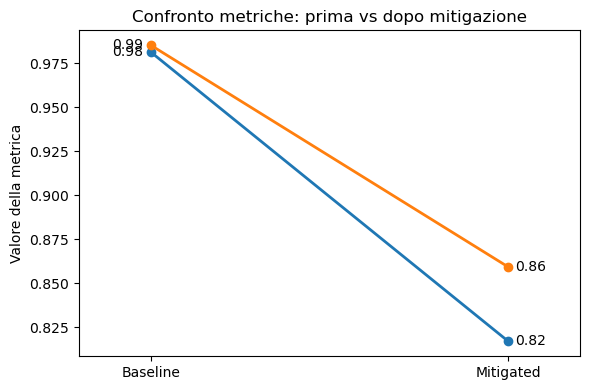

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Report testuale
print("=== BASELINE PERFORMANCE ===")
print(classification_report(y_test, y_pred_base))
print("=== AFTER DROPPING CITY AND OCCUPATION ===")
print(classification_report(y_test, y_pred_nb))

# 2) Costruzione tabella delle metriche
metrics_summary = pd.DataFrame({
    "Metric": ["Accuracy", "F1_macro"],
    "Baseline": [
        accuracy_score(y_test, y_pred_base),
        f1_score(y_test, y_pred_base, average="macro")
    ],
    "Mitigated": [
        accuracy_score(y_test, y_pred_nb),
        f1_score(y_test, y_pred_nb, average="macro")
    ]
})

display(metrics_summary.style.format({"Baseline": "{:.4f}", "Mitigated": "{:.4f}"}))

# 3) Slope chart per il confronto visivo
metrics_summary_plot = metrics_summary.set_index("Metric")
x = [0, 1]  # 0 = baseline, 1 = mitigated

fig, ax = plt.subplots(figsize=(6, 4))

for metric in metrics_summary_plot.index:
    y0 = metrics_summary_plot.loc[metric, "Baseline"]
    y1 = metrics_summary_plot.loc[metric, "Mitigated"]
    ax.plot(x, [y0, y1], marker='o', linewidth=2)
    ax.text(x[0] - 0.02, y0, f"{y0:.2f}", va="center", ha="right")
    ax.text(x[1] + 0.02, y1, f"{y1:.2f}", va="center", ha="left")

ax.set_xticks(x)
ax.set_xticklabels(["Baseline", "Mitigated"])
ax.set_xlim(-0.2, 1.2)
ax.set_ylabel("Valore della metrica")
ax.set_title("Confronto metriche: prima vs dopo mitigazione")
plt.tight_layout()
plt.show()


## 6- Summary Comparison

Tabulate & plot accuracy before vs after mitigation.


,Metric,Baseline,No City & Occupation
0,Accuracy,0.9815,0.8170
1,F1_macro,0.9854,0.8593


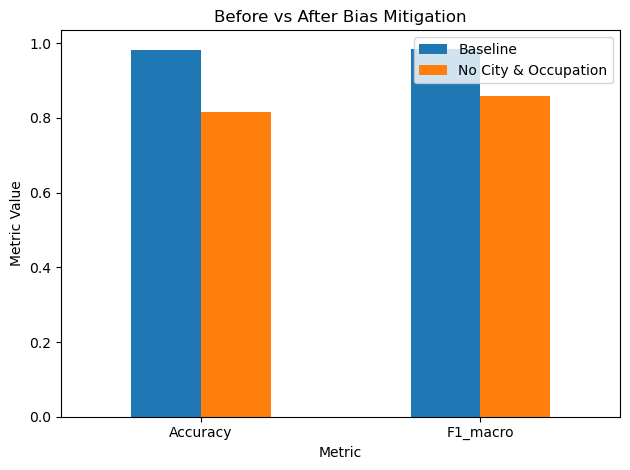

In [20]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Recompute metrics for the mitigated model (no City & Occupation)
acc_mit = accuracy_score(y_test, y_pred_nb)
f1_mit  = f1_score     (y_test, y_pred_nb, average='macro')

# Build summary table
metrics_summary = pd.DataFrame({
    "Metric": ["Accuracy", "F1_macro"],
    "Baseline": [np.round(acc_base, 4), np.round(f1_base, 4)],
    "No City & Occupation": [np.round(acc_mit, 4), np.round(f1_mit, 4)]
})

display(metrics_summary)

# Plot side‐by‐side bar chart
ax = (
    metrics_summary
      .set_index("Metric")[["Baseline","No City & Occupation"]]
      .plot.bar(rot=0)
)
ax.set_title("Before vs After Bias Mitigation")
ax.set_ylabel("Metric Value")
plt.tight_layout()
plt.show()
